(150, 4) (4, 2) (2,)
Classification accuracy: 0.91


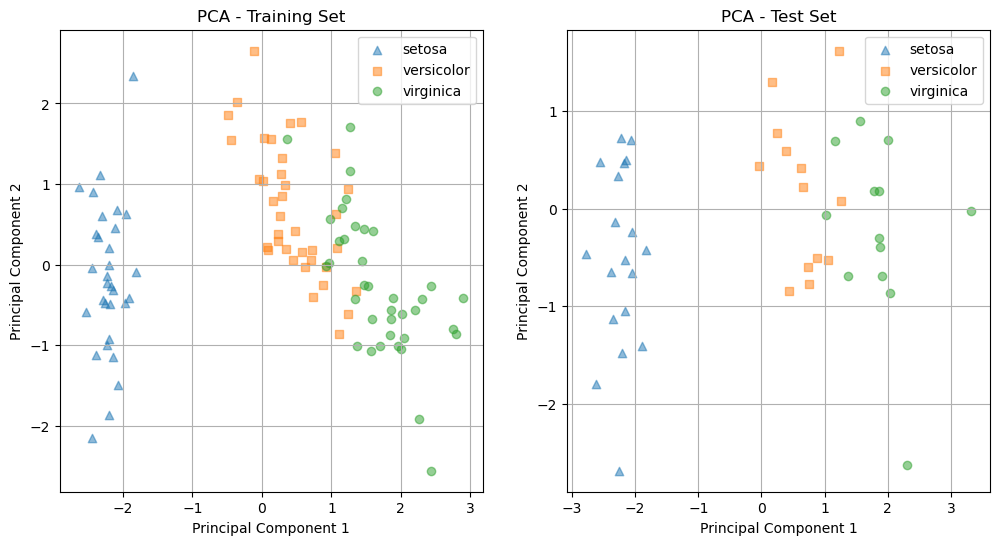

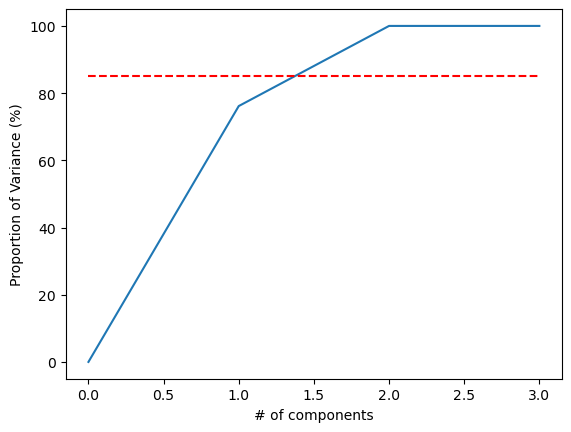

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score\


# Plotting the original Iris dataset before PCA transformation
# Loading the Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Function to sort eigenvalues and eigenvectors
def eigsort(A):
    eigvals, U = np.linalg.eig(A)
    # sort eigenvalues in descending order (we multiply the matrix with -1)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    #re-arrange the eigenvectors
    U = U[:, order]
    return U, eigvals

# Function to perform classic PCA
def pca_classic(X, M):
    #για κάθε στήλη του πίνακα X υπολογίστε το μέσο όρο, και αποθηκεύστε το σε διάνυσμα γραμμής
    mu = X.mean(axis=0).reshape( (1,-1) )
    #αφαιρέστε το μέσο όρο από τον πίνακα
    normalized_X = X-mu
    #υπολογίστε το Covariance matrix για τον πίνακα του προηγούμενου βήματος
    S = (1/X.shape[0]) * normalized_X.T.dot( normalized_X )
    #υπολογίστε τα ιδιοδιανύσματα και τις ιδιοτιμές του covariance πίνακα
    eigvectors, eigvals = eigsort( S )
    #κρατήστε στον πίνακα U τις πρώτες Μ στήλες των ιδιοδιανυσμάτων
    U = eigvectors[:,:M]
    #κρατήστε στον πίνακα Lambads τις πρώτες Μ ιδιοτιμές
    Lambdas = eigvals[:M]
    print( X.shape, U.shape, Lambdas.shape )
    #αποθηκεύστε το μετασχηματισμό Z = U * X ( προσέξτε τις διαστάσεις )
    #ο πίνακας U εφαρμόζεται στον κανονικοποιημένο πίνακα X και τον προβάλει
    #επάνω στα ιδιοδιανύσματα(μειωμένη διάσταση)
    Z = normalized_X.dot(U)
    return Z, U, Lambdas, mu

# Standardize the iris dataset

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_iris)

# Apply PCA to the Iris dataset (reducing to 2 dimensions)
M = 2
Z, eigvecs, eigvals, mu = pca_classic(X_scaled, M)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Z, y_iris, test_size=0.3, random_state=42)

# Train a Logistic Regression classifier
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy: {accuracy:.2f}")

# Function to plot the PCA-transformed data
def plot_pca(Z, y, title="PCA-transformed data", markers=('^', 's', 'o')):
    # Unique classes in the dataset
    classes = np.unique(y)

    # Plotting each class with a unique marker and color
    for i, cls in enumerate(classes):
        plt.scatter(Z[y == cls, 0], Z[y == cls, 1], alpha=0.5, marker=markers[i], label=iris.target_names[cls])

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)

# Plotting the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_pca(X_train, y_train, title="PCA - Training Set")

# Plotting the test set
plt.subplot(1, 2, 2)
plot_pca(X_test, y_test, title="PCA - Test Set")

plt.show()

# plot the proportion of explained variance for components
x = range(X_iris.shape[1])
y = [np.sum(eigvals[:m].astype('float'))/np.sum(eigvals.astype('float'))*100 for m in x]

plt.plot(x, y)
plt.plot(x,[85]*len(x), 'r--')
plt.ylabel("Proportion of Variance (%)")
plt.xlabel("# of components")
plt.show()


Sklearn PCA Classification accuracy: 0.91


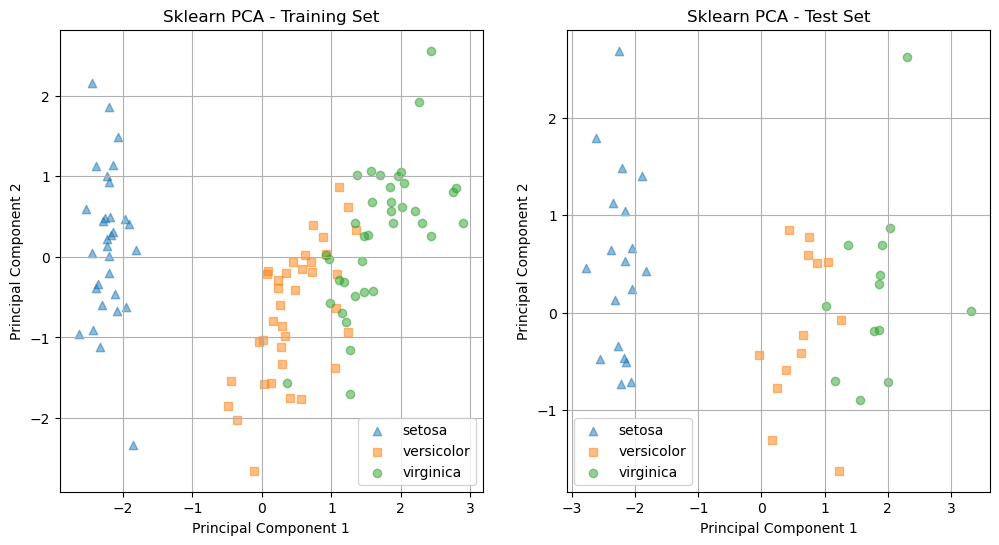

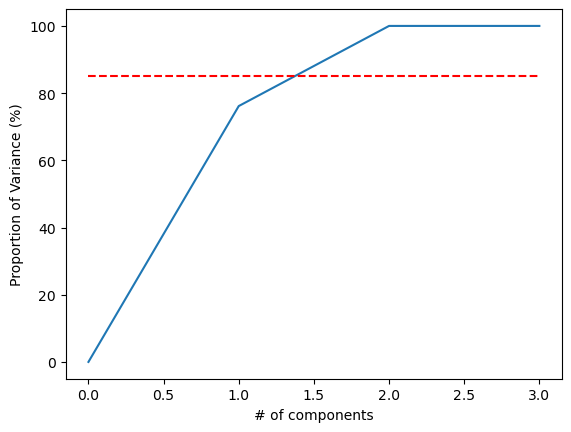

In [2]:
# Using PCA from sklearn
from sklearn.decomposition import PCA

# Applying PCA from sklearn
pca_sklearn = PCA(n_components=M, svd_solver='full')
Z_sklearn = pca_sklearn.fit_transform(X_scaled)

# Split the dataset into training and testing sets
X_train_sklearn, X_test_sklearn, y_train_sklearn, y_test_sklearn = train_test_split(Z_sklearn, y_iris, test_size=0.3, random_state=42)

# Train a Logistic Regression classifier on sklearn PCA-transformed data
clf_sklearn = LogisticRegression(random_state=42)
clf_sklearn.fit(X_train_sklearn, y_train_sklearn)

# Predict and calculate accuracy for sklearn PCA
y_pred_sklearn = clf_sklearn.predict(X_test_sklearn)
accuracy_sklearn = accuracy_score(y_test_sklearn, y_pred_sklearn)
print(f"Sklearn PCA Classification accuracy: {accuracy_sklearn:.2f}")

# Plotting the training set for sklearn PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_pca(X_train_sklearn, y_train_sklearn, title="Sklearn PCA - Training Set")

# Plotting the test set for sklearn PCA
plt.subplot(1, 2, 2)
plot_pca(X_test_sklearn, y_test_sklearn, title="Sklearn PCA - Test Set")

plt.show()

# plot the proportion of explained variance for components
x = range(X_iris.shape[1])
y = [np.sum(eigvals[:m].astype('float'))/np.sum(eigvals.astype('float'))*100 for m in x]

plt.plot(x, y)
plt.plot(x,[85]*len(x), 'r--')
plt.ylabel("Proportion of Variance (%)")
plt.xlabel("# of components")
plt.show()
